In [1]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms, models, datasets
import numpy as np
import json

mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std  = np.array([0.229, 0.224, 0.225], dtype=np.float32)
inv_norm = transforms.Normalize(mean=(-mean / std).tolist(), std=(1 / std).tolist())

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean.tolist(), std.tolist())])
dataset = datasets.ImageFolder(root="TestDataSet", transform=transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)

with open("TestDataSet/labels_list.json") as f:
    idx2true = {i: int(e.split(":",1)[0]) for i, e in enumerate(json.load(f))}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1).to(device)
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [2]:
pgd_5 = torch.load("PGD-Targeted-Step-5.pt")
pgd_10 = torch.load("PGD-Targeted-Step-10.pt")
pgd_15 = torch.load("PGD-Targeted-Step-15.pt")

pgd_5_images = pgd_5["images"]
pgd_10_images = pgd_10["images"]
pgd_15_images = pgd_15["images"]
labels = pgd_5["labels"]

orig_images = []
for x, _ in loader:
    orig_images.append(x)
    if len(orig_images) * 64 >= len(pgd_5_images):
        break
orig_images = torch.cat(orig_images)[:len(pgd_5_images)].to(device)


In [3]:
@torch.no_grad()
def get_predictions(model, tensor, batch_size=64):
    preds = []
    for i in range(0, len(tensor), batch_size):
        batch = tensor[i:i+batch_size].to(device)
        logits = model(batch)
        preds.extend(logits.argmax(1).cpu())
    return torch.tensor(preds)

clean_preds = get_predictions(model, orig_images)
pgd_5_preds = get_predictions(model, pgd_5_images)
pgd_10_preds = get_predictions(model, pgd_10_images)
pgd_15_preds = get_predictions(model, pgd_15_images)
true_labels = torch.tensor([idx2true[int(l)] for l in labels])


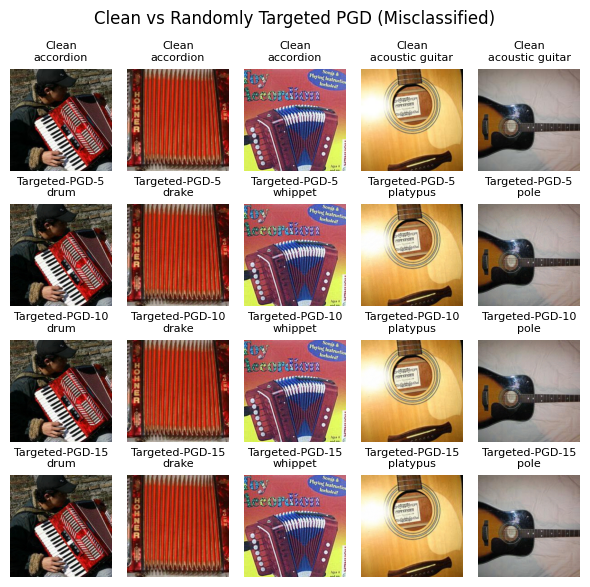

In [4]:
all_labels = models.ResNet34_Weights.IMAGENET1K_V1.meta["categories"]

picked = []
for i, (c, p5, p10, p15, t) in enumerate(zip(clean_preds, pgd_5_preds, pgd_10_preds, pgd_15_preds, true_labels)):
    if c == t and (p5 != t or p10 != t or p15 != t):
        picked.append(i)
    if len(picked) >= 5:
        break

fig, axes = plt.subplots(4, len(picked), figsize=(6, 6))
names = ["Clean", "Targeted-PGD-5", "Targeted-PGD-10", "Targeted-PGD-15"]
image_sets = [orig_images, pgd_5_images, pgd_10_images, pgd_15_images]
pred_sets  = [clean_preds, pgd_5_preds, pgd_10_preds, pgd_15_preds]

for row in range(4):
    for col, i in enumerate(picked):
        img = inv_norm(image_sets[row][i].cpu()).permute(1, 2, 0).clamp(0, 1)
        pred_label = all_labels[pred_sets[row][i]]
        axes[row, col].imshow(img)
        axes[row, col].axis("off")
        axes[row, col].set_title(f"{names[row]}\n{pred_label}", fontsize=8)

plt.suptitle("Clean vs Randomly Targeted PGD (Misclassified)", fontsize=12)
plt.tight_layout()
plt.show()
